In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import os
import albumentations as A
import cv2
from torchvision.transforms import ToTensor

from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

from utils.data_preprocessing import get_lips_twins, get_train_test_dataset
from utils.dataloaders import LipstickDataset

In [2]:
dataset_path = Path('/home/e_radionova/Datasets/Lipstick')

In [3]:
# get_train_test_dataset(dataset_path = dataset_path, 
#                        images_path = '720p', 
#                        masks_path = 'mask',
#                        dataset_dir = 'dataset', 
#                        train_fold = 'train', 
#                        test_fold = 'val',
#                        img_fold = 'imags', 
#                        masks_fold = 'masks', 
#                        test_size = 0.3)

In [4]:
trans = A.Compose([
#     A.Resize(750, 1000),
      A.RandomCrop(width=544, height=544),
      A.RandomRotate90(p=1),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.8),
                  ])

train_set = LipstickDataset(images_folder = dataset_path / 'dataset/train/imags', 
                         masks_folder = dataset_path / 'dataset/train/masks',
                         transform = trans)

val_set = LipstickDataset(images_folder = dataset_path / 'dataset/val/imags', 
                         masks_folder = dataset_path / 'dataset/val/masks',
                         transform = trans)

In [5]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 4
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 200, 'val': 86}

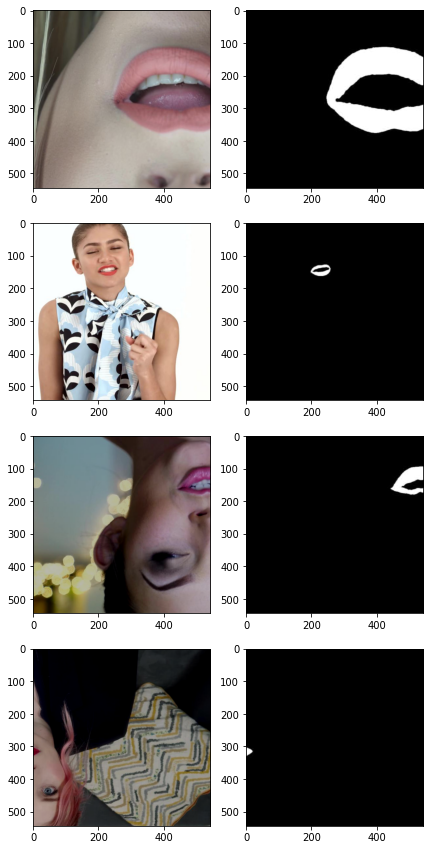

In [6]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = batch_size_train
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(7, 15))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i] 
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0) 
#     print(np.unique(label_np))
    ax[i,0].imshow(pic_np, cmap='gray')
    ax[i,1].imshow(label_np, cmap='gray')

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
import torch.nn.functional as F
from utils.loss import dice_loss, calc_loss, print_metrics
# from attention_maps_funcs import get_activation, plot_attention_map
from tqdm.notebook import tqdm

In [8]:
logs_base_dir = Path('./logs_lipstick')
logs_base_dir.mkdir(exist_ok=True)

In [9]:
import torchvision.transforms.functional as F
import torch.nn.functional as func

In [10]:
file_name = 'test_lipstick_augs_1channel'

In [11]:
def train_model(model, optimizer, scheduler, experiment_name, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 0
    
    writer = SummaryWriter(logs_base_dir / experiment_name)

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()
        i=0
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train': 
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.float()
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                epoch_samples += inputs.size(0)
                

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples   
            writer.add_scalar(f'Loss_{phase}', epoch_loss.item(), global_step=epoch)
            
            dice_epoch = metrics['dice'] / epoch_samples
            writer.add_scalar(f'DICE_{phase}', dice_epoch.item(), global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best loss")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
#                 torch.save(model.state_dict(), f'./birds_weights/{experiment_name}.pth')
            
            if phase == 'val' and dice_epoch > best_dice:
                print("saving best DICE")
                best_dice = dice_epoch

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val DICE: {:4f}'.format(best_dice))
     
#     with open(f"./metrics_txt/{file_name}.txt","a") as the_file:
#             the_file.write('best DICE: {}\n'.format(best_dice))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

from models import unet
model = unet.UNet(3,1).to(device)

In [14]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

exp_name = f'{file_name}_' + datetime.now().isoformat(timespec='minutes') 

In [ ]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, experiment_name=exp_name, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------
LR 0.001


/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/50 [00:00<?, ?it/s]

/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.403219, dice: 0.053654, loss: 0.674782


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.055940, dice: 0.012798, loss: 0.521571
saving best loss
saving best DICE
0m 28s
Epoch 1/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.044158, dice: 0.155293, loss: 0.444432


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.035755, dice: 0.506082, loss: 0.264837
saving best loss
saving best DICE
0m 28s
Epoch 2/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.166988, dice: 0.213915, loss: 0.476537


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.057331, dice: 0.496433, loss: 0.280449
0m 28s
Epoch 3/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.192061, dice: 0.536903, loss: 0.327579


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.065111, dice: 0.601031, loss: 0.232040
saving best loss
saving best DICE
0m 28s
Epoch 4/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.093459, dice: 0.632643, loss: 0.230408


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.102922, dice: 0.639086, loss: 0.231918
saving best loss
saving best DICE
0m 28s
Epoch 5/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.064855, dice: 0.689365, loss: 0.187745


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.048436, dice: 0.551133, loss: 0.248652
0m 28s
Epoch 6/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.056008, dice: 0.650103, loss: 0.202952


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.061754, dice: 0.674034, loss: 0.193860
saving best loss
saving best DICE
0m 28s
Epoch 7/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.063471, dice: 0.666510, loss: 0.198481


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.032462, dice: 0.603967, loss: 0.214248
0m 28s
Epoch 8/49
----------
LR 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.062895, dice: 0.682452, loss: 0.190221


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.045026, dice: 0.690030, loss: 0.177498
saving best loss
saving best DICE
0m 28s
Epoch 9/49
----------
LR 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.044879, dice: 0.690289, loss: 0.177295


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.042759, dice: 0.716037, loss: 0.163361
saving best loss
saving best DICE
0m 28s
Epoch 10/49
----------
LR 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.040296, dice: 0.723181, loss: 0.158557


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.046265, dice: 0.713220, loss: 0.166522
0m 28s
Epoch 11/49
----------
LR 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.040045, dice: 0.711423, loss: 0.164311


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.052493, dice: 0.716433, loss: 0.168030
saving best DICE
0m 28s
Epoch 12/49
----------
LR 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

train: bce: 0.045486, dice: 0.737689, loss: 0.153898


  0%|          | 0/22 [00:00<?, ?it/s]

val: bce: 0.047685, dice: 0.753833, loss: 0.146926
saving best loss
saving best DICE
0m 28s
Epoch 13/49
----------
LR 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]